<a href="https://colab.research.google.com/github/soleildeminuit/AI-Samhallsplanering-Course/blob/main/notebooks/Link%C3%B6ping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching location names...
   locationId                                               name
0         343  2005880AP112_City_of_Linköping_Trädgardsföreni...
1         180         2005880AP180_City_of_Linköping_Resecentrum
2         182         2005880AP182_City_of_Linköping_Resecentrum
3         426           2005880AP184_CoL_NykvarnsparkenNorthside
4         427                 2005880AP186_CoL_NykvarnsparkenMid
5         428              2005880AP187_CoL_NykvarnsparkenBridge
6         277  2005880AP41_City_of_Linköping_Trädgardsförenin...
7         278  2005880AP42_City_of_Linköping_Trädgardsförenin...
8         279  2005880AP44_City_of_Linköping_Trädgardsförenin...
9         284  2005880AP60_City_of_Linköping_Trädgardsförenin...
Fetching flow data from 277 to 278...


<Figure size 1200x600 with 0 Axes>

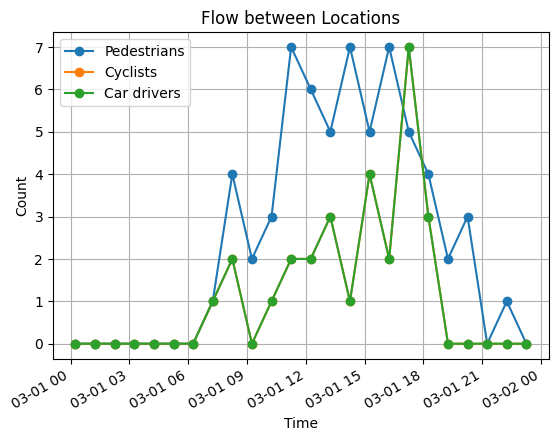

Fetching location data for 277...


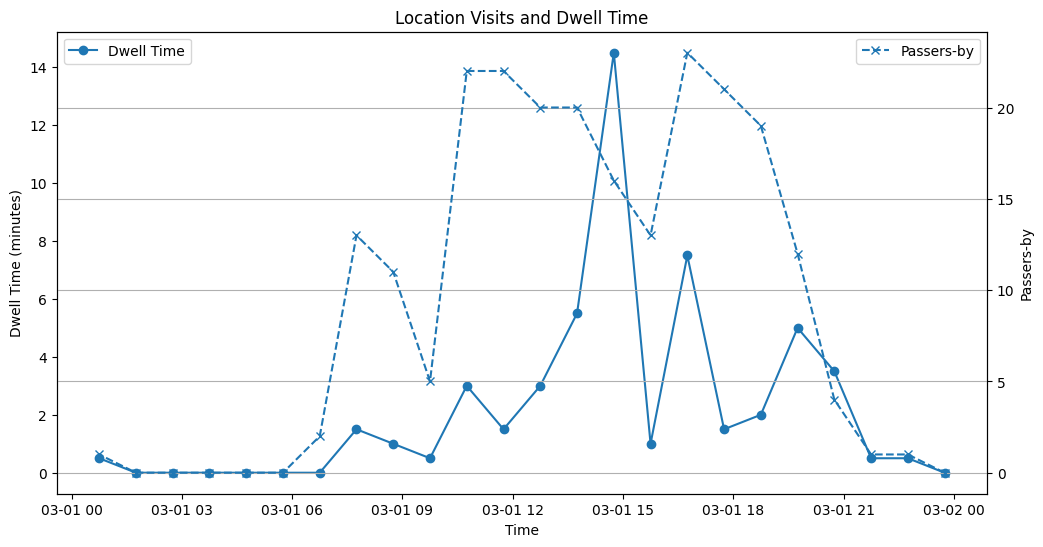

In [1]:
# Linköping Mobility Patterns Visualization Script
# Designed to run in Google Colab

# If necessary, uncomment the following line to install dependencies:
# !pip install requests pandas matplotlib

import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Base URL for the Rörelsedata API
BASE_URL = "https://rorelsemonster.linkoping.se/api/v1"


def get_location_names():
    """
    Fetches all available location names and their IDs.
    Returns:
        pd.DataFrame: Columns [locationId, name]
    """
    url = f"{BASE_URL}/LocationNames"
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json()
    return pd.DataFrame(data)


def get_flow_data(from_id: int, to_id: int, start: str, end: str, aggregation: str = "Hour") -> pd.DataFrame:
    """
    Fetches flow data between two locations over a time range.
    Args:
        from_id (int): Source location ID
        to_id (int): Destination location ID
        start (str): ISO datetime string, e.g. "2021-03-01T00:00:00"
        end (str): ISO datetime string, e.g. "2021-03-02T00:00:00"
        aggregation (str): One of [HalfAnHour, Hour, Day, Week]
    Returns:
        pd.DataFrame indexed by registeredTime
    """
    params = {
        "From_Location_Id": from_id,
        "To_Location_Id": to_id,
        "From_DateTime": start,
        "To_DateTime": end,
        "aggregation": aggregation
    }
    resp = requests.get(f"{BASE_URL}/FlowData", params=params)
    resp.raise_for_status()
    df = pd.DataFrame(resp.json())
    df['registeredTime'] = pd.to_datetime(df['registeredTime'])
    return df.set_index('registeredTime')


def get_location_data(location_id: int, start: str, end: str, aggregation: str = "Hour") -> pd.DataFrame:
    """
    Fetches visit and dwell data for a single location.
    Args:
        location_id (int): Location ID
        start (str): ISO datetime string
        end (str): ISO datetime string
        aggregation (str): One of [HalfAnHour, Hour, Day, Week]
    Returns:
        pd.DataFrame indexed by registeredTime
    """
    params = {
        "Location_Id": location_id,
        "From_DateTime": start,
        "To_DateTime": end,
        "aggregation": aggregation
    }
    resp = requests.get(f"{BASE_URL}/LocationData", params=params)
    resp.raise_for_status()
    df = pd.DataFrame(resp.json())
    df['registeredTime'] = pd.to_datetime(df['registeredTime'])
    return df.set_index('registeredTime')


def plot_flow(df: pd.DataFrame):
    """
    Time-series plot of flows by transport mode.
    """
    plt.figure(figsize=(12, 6))
    df[['flowPedestrians', 'flowCyclists', 'flowCarDrivers']].plot(marker='o')
    plt.title("Flow between Locations")
    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.legend(["Pedestrians", "Cyclists", "Car drivers"])
    plt.grid(True)
    plt.show()


def plot_location(df: pd.DataFrame):
    """
    Combined plot of dwell time and passers-by counts for a location.
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(df.index, df['dwellTime'], marker='o', label='Dwell Time')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Dwell Time (minutes)")
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(df.index, df['passersBy'], marker='x', linestyle='--', label='Passers-by')
    ax2.set_ylabel("Passers-by")
    ax2.legend(loc='upper right')

    plt.title("Location Visits and Dwell Time")
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    # Example usage parameters
    from_id = 277
    to_id = 278
    location_id = 277
    start = "2021-03-01T00:00:00"
    end = "2021-03-02T00:00:00"
    aggregation = "Hour"

    print("Fetching location names...")
    locs = get_location_names()
    print(locs[['locationId', 'name']])

    print(f"Fetching flow data from {from_id} to {to_id}...")
    flow_df = get_flow_data(from_id, to_id, start, end, aggregation)
    plot_flow(flow_df)

    print(f"Fetching location data for {location_id}...")
    loc_df = get_location_data(location_id, start, end, aggregation)
    plot_location(loc_df)
